In [336]:
# %config Completer.use_jedi = True

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
# from pandas_profiling import ProfileReport

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 

### Импорт

Через Kaggle API

In [22]:
# !/home/a-zverev/anaconda3/bin/kaggle datasets download -d mirichoi0218/insurance
!kaggle datasets download -d mirichoi0218/insurance
!unzip insurance.zip 
!rm insurance.zip
%ll -ht

  0%|                                               | 0.00/16.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 9.86MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           
total 2.3M
-rw-rw-r-- 1 a-zverev 2.3M Mar 15 19:17 insurance.ipynb
-rw-rw-r-- 1 a-zverev   11 Mar 15 18:59 README.md
-rw-rw-r-- 1 a-zverev  55K Sep 27  2019 insurance.csv


### EDA

In [23]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Выборка неравновесная - курильщиков сильно больше \
Максимальное количество детей - пять.

In [49]:
prof = ProfileReport(df)

In [50]:
prof

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [222]:
df.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


По регионам и полу группы более-менее сбалансированы.

In [223]:
df.groupby(['region', 'sex']).count()

age  bmi  children  smoker  charges
region    sex                                        
northeast female  161  161       161     161      161
          male    163  163       163     163      163
northwest female  164  164       164     164      164
          male    161  161       161     161      161
southeast female  175  175       175     175      175
          male    189  189       189     189      189
southwest female  162  162       162     162      162
          male    163  163       163     163      163

NA нет

In [224]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Распределение по стоимости страховки - даже близко не нормально. \
Страховка может сильно зависить от возраста, слабее от bmi. \
bmi слабо коррелирует с возрастом.

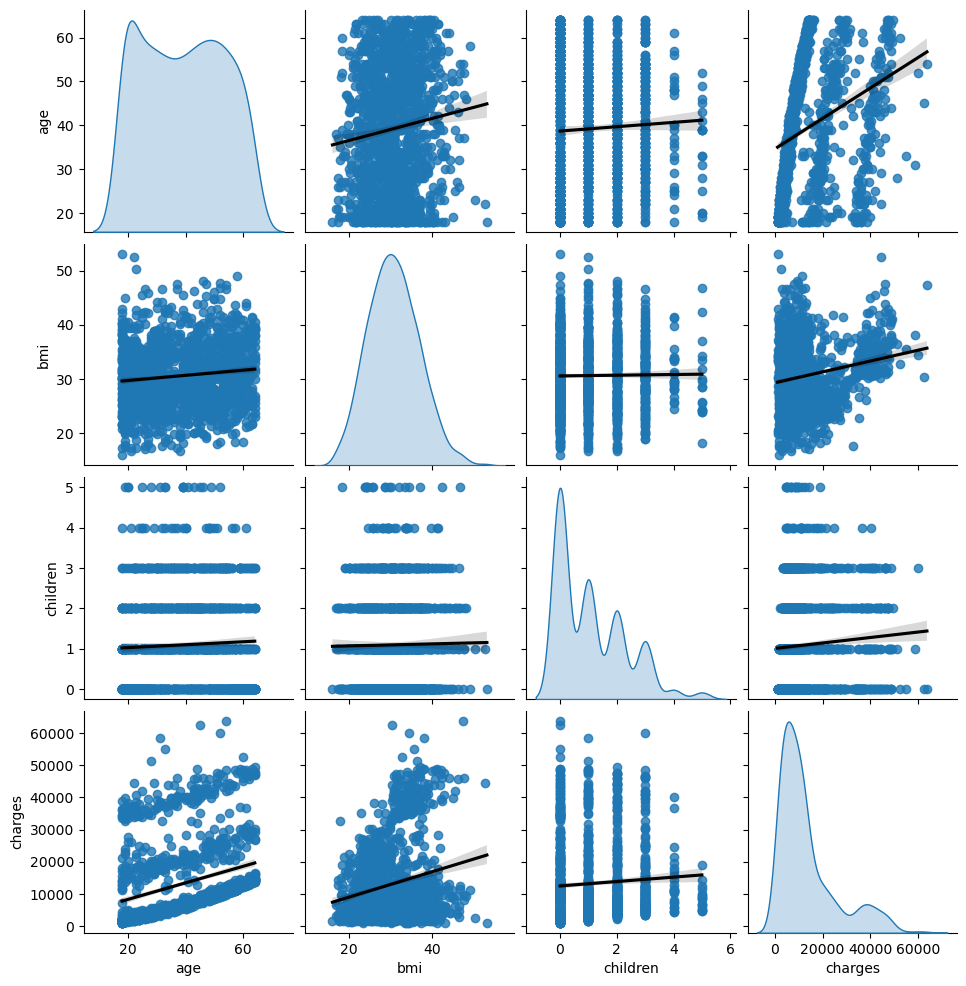

In [225]:
sns.pairplot(df, kind='reg', diag_kind='kde', plot_kws= {'line_kws': {'color':'black'}});

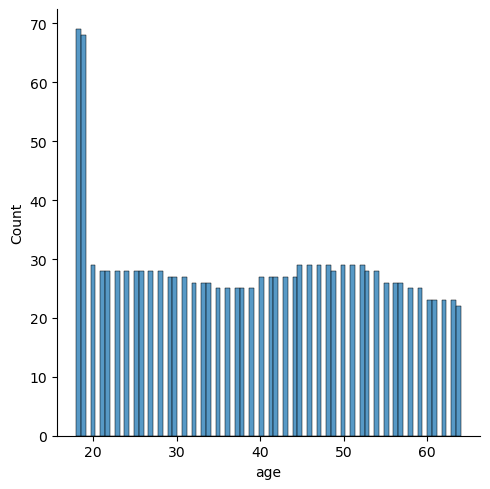

In [30]:
sns.displot(df, x="age", bins = 80);

По регионам примерно одно и то же. 

Страховка для курильщиков выше. \
Для курильщиков бимодальное распределение?

?Три кластера - низкая стоимость страховки, около 20k, около 40k


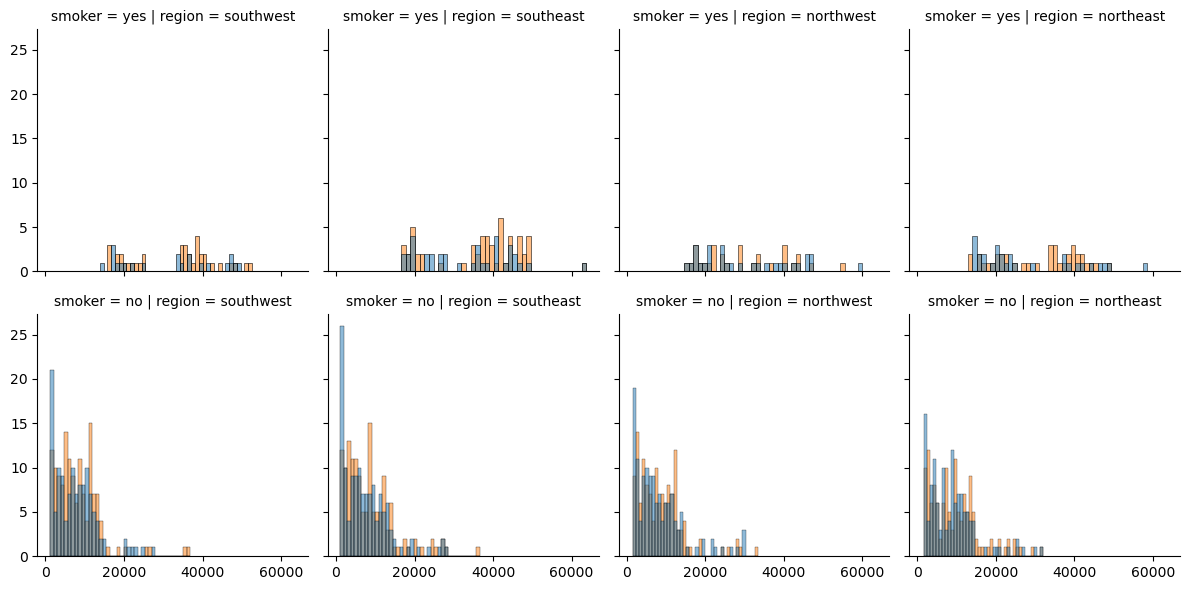

In [31]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="charges", hue="sex", bins=40);

По возрасту равномерное распределение с пиком на 18-19.

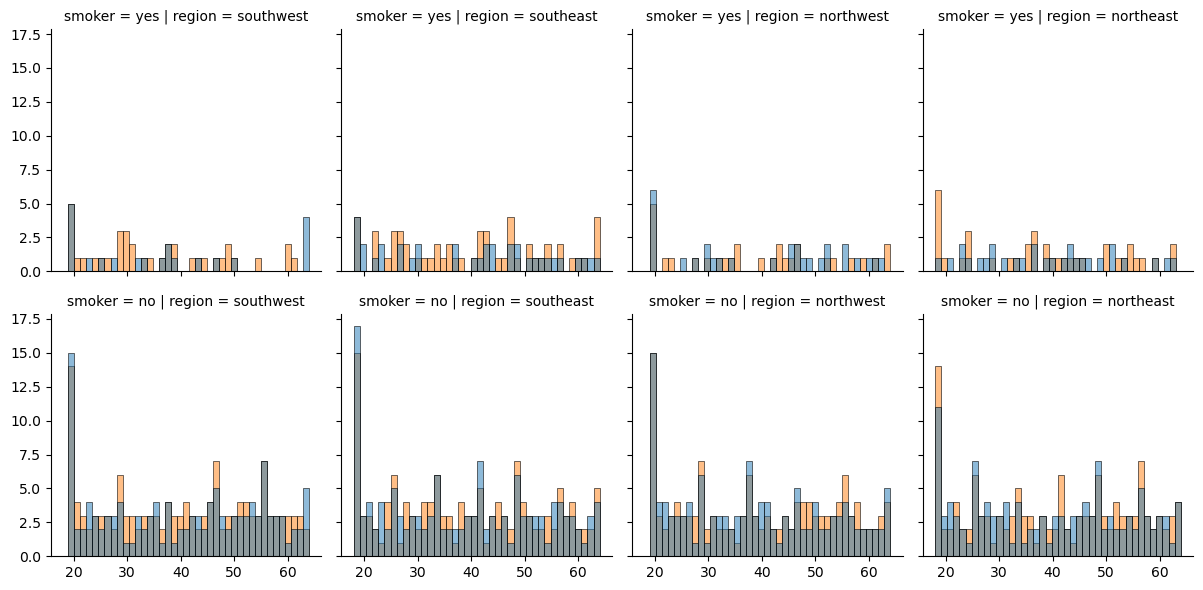

In [32]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="age", hue="sex", bins=40);

Распределение по жирности нормальное.

?В southeast лиди толще?

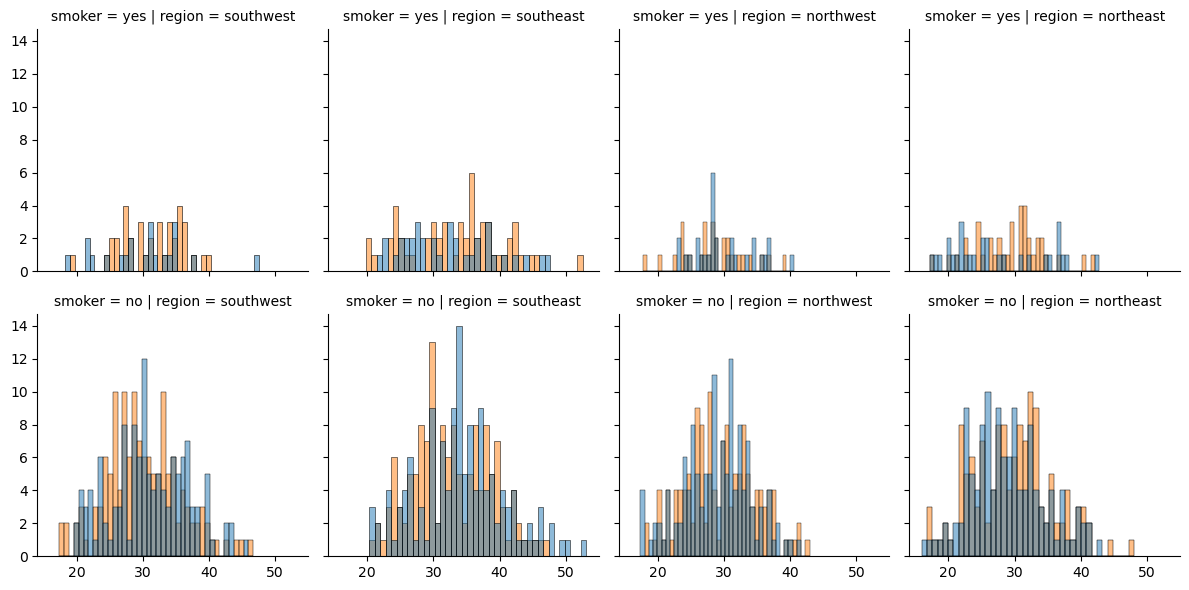

In [33]:
g = sns.FacetGrid(df, col="region", row="smoker")
g.map_dataframe(sns.histplot, x="bmi", hue="sex", bins=40);

Количество детей по региону и полу.

Различия в поле не заметно. Мужики не бросают насовсем?\
По региону тоже не заметно различий(?northwest)

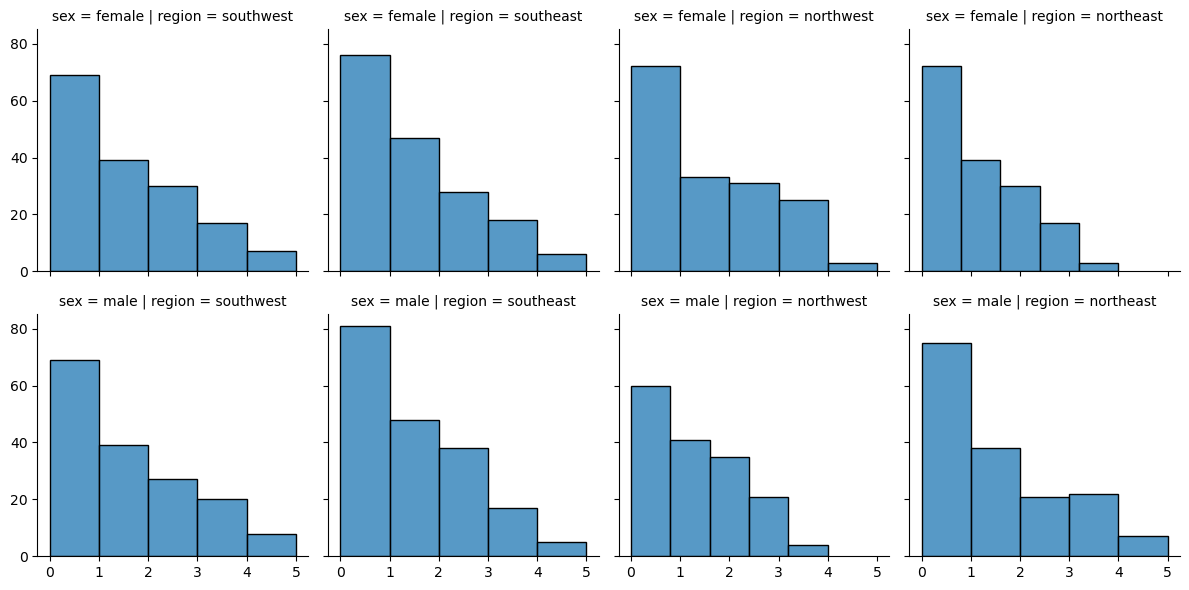

In [34]:
g = sns.FacetGrid(df, col="region", row="sex")
g.map_dataframe(sns.histplot, x="children", bins=5);

### Подбор групп

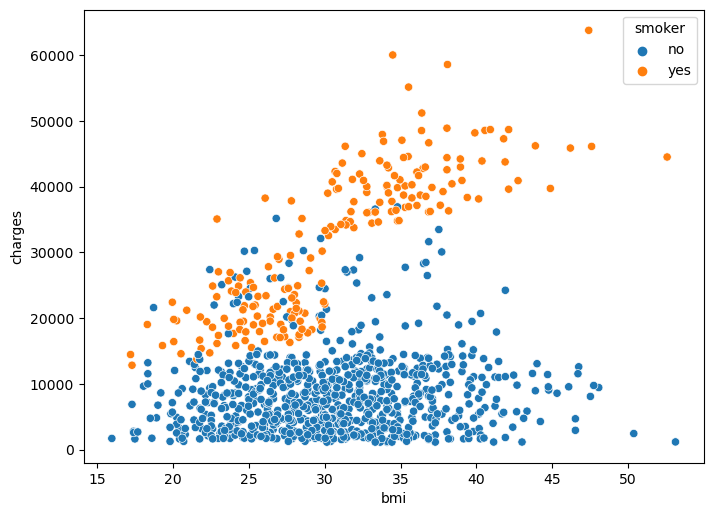

In [305]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=train);

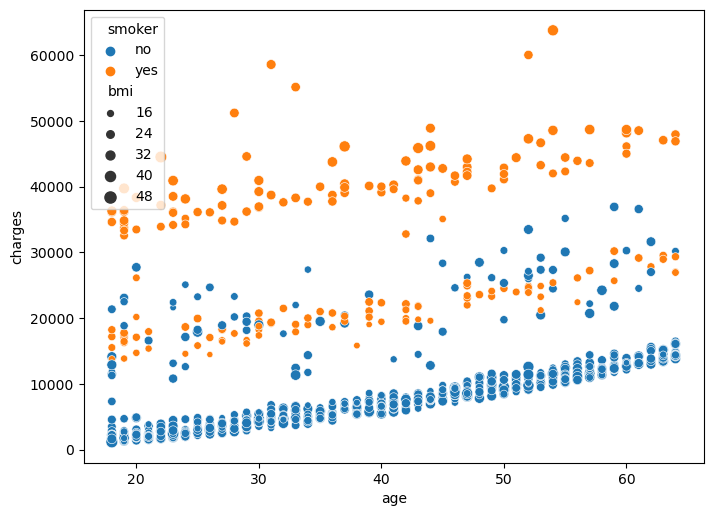

In [306]:
sns.scatterplot(x='age', y='charges', hue='smoker', size='bmi', data=train);

Попробуем понять, кто дает нам такое странное распределение, и попытаемся отфильтровать их на три группы

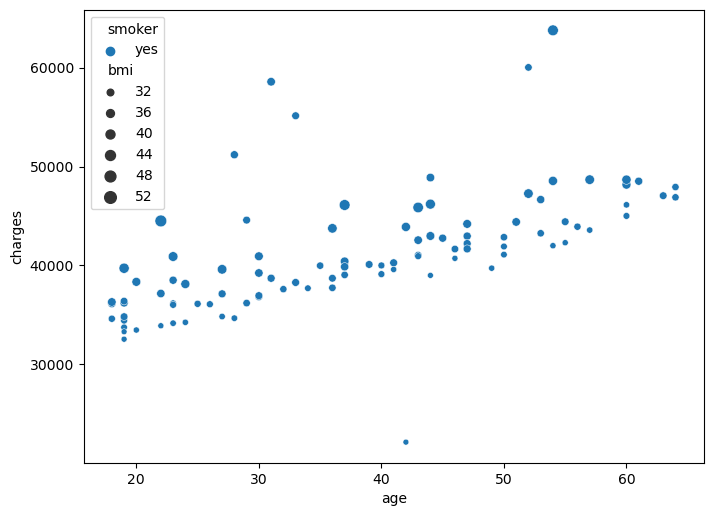

In [307]:
sns.scatterplot(x='age', y='charges', hue='smoker', size='bmi',
                data=train.query("(smoker == 'yes') & (bmi >= 30)"));

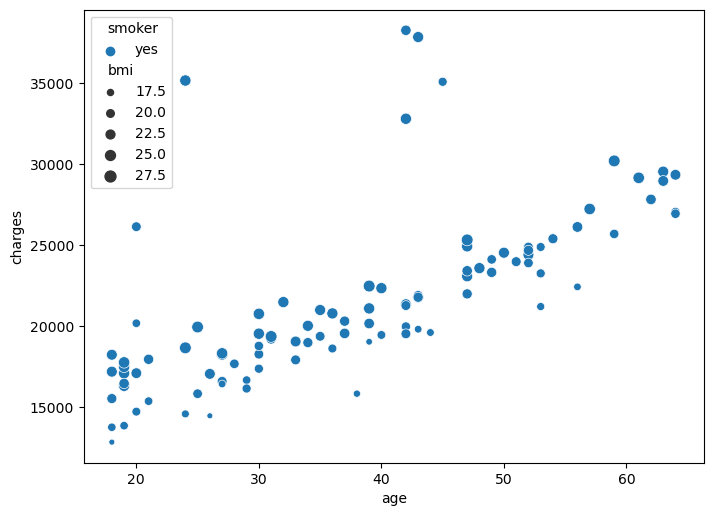

In [308]:
sns.scatterplot(x='age', y='charges', hue='smoker', size='bmi', 
                data=train.query("(smoker == 'yes') & (bmi < 30)"));

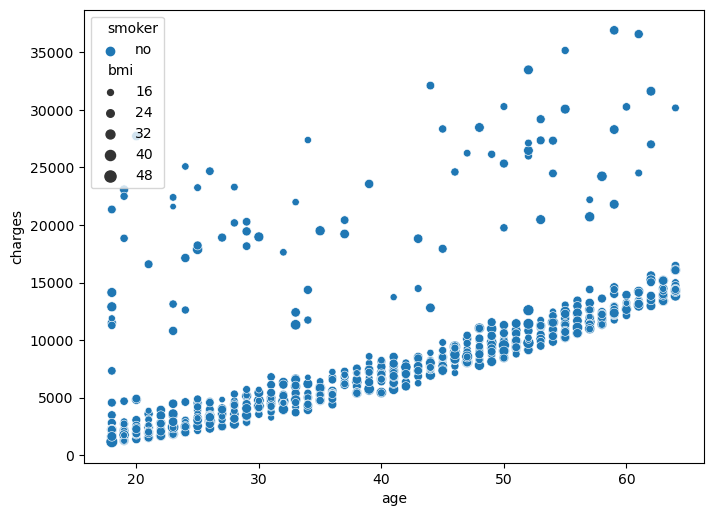

In [309]:
sns.scatterplot(x='age', y='charges', hue='smoker', size='bmi', 
                data=train.query("(smoker == 'no')"));

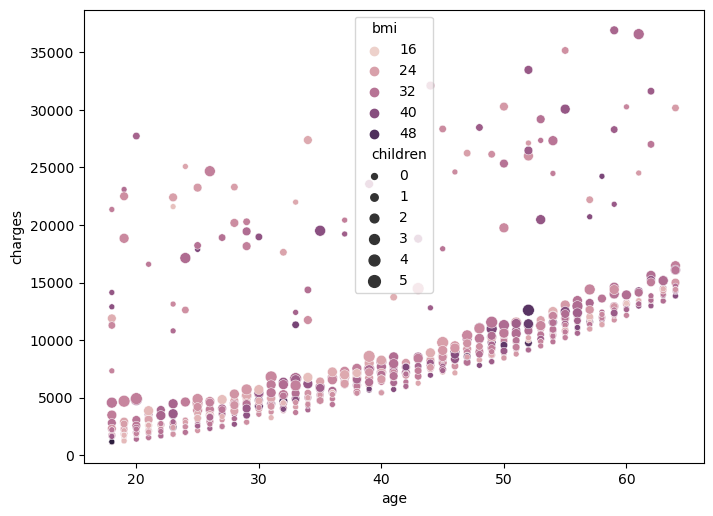

In [310]:
sns.scatterplot(x='age', y='charges', size='children', hue='bmi', 
                data=train.query("(smoker == 'no')"));

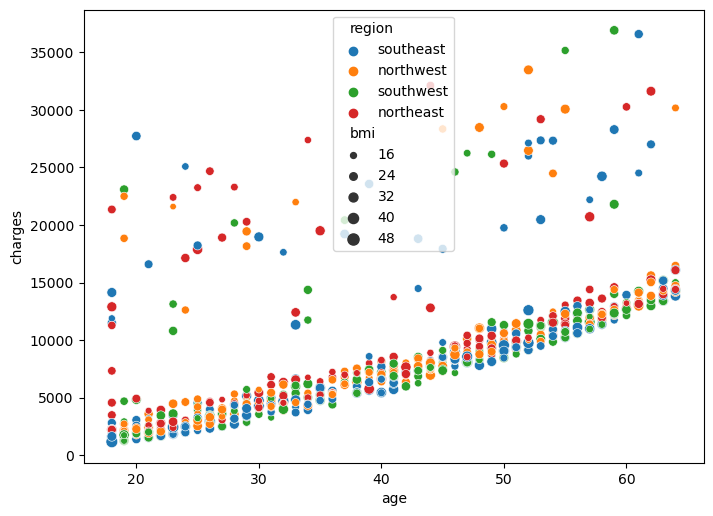

In [311]:
sns.scatterplot(x='age', y='charges', hue='region', size='bmi', 
                data=train.query("(smoker == 'no')"));

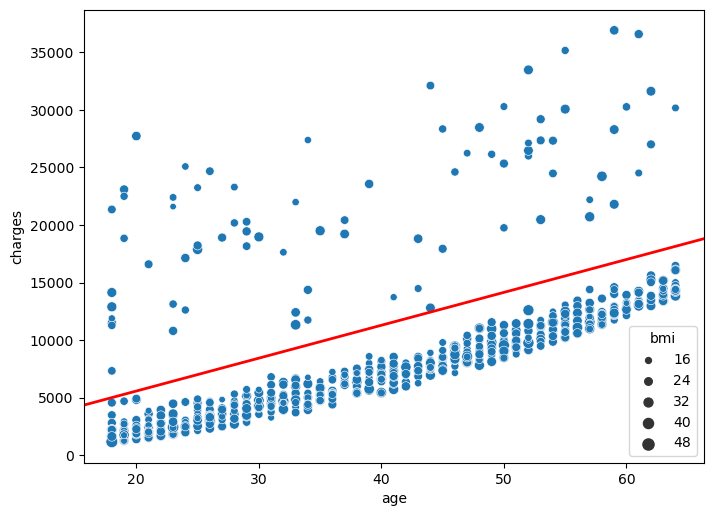

In [313]:
sns.scatterplot(x='age', y='charges', size='bmi', 
                data=train.query("smoker == 'no'"));
plt.axline((18, 5000), (60, 17000), linewidth=2, color='r');

Собственно, мы можем собрать следующие группы:

* Курильщики с bmi > 30. Самая дорогая страховка. Перекрывает весь верхний кластер на charges - age плоте
* Курильщики с bmi < 30. Получше, но все равно дорого. Перекрывает часть второго кластера на charges - age плоте
* Некурящие, составляющие нижний кластер. Данные, входящие в верхний кластер, предлагаю отрезать, поскольку они никак не зависят ни от одной из наших переменных, и считать их отклонениями.

In [381]:
fit = lambda x: 148 + 286*x

conditions = [
    ((df['smoker'] == 'yes') & (df['bmi'] >= 30)),
    ((df['smoker'] == 'yes') & (df['bmi'] < 30)),
    ((df['smoker'] == 'no') & (df['charges'] < fit(df['age'])))
]

choices = ['heavy_smokers', 'normal_smokers', 'regular']
df['group'] = np.select(conditions, choices, default='unknown')

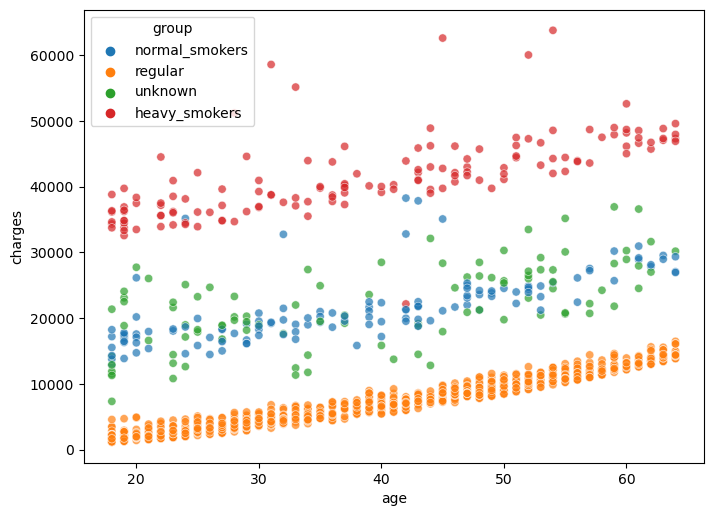

In [382]:
sns.scatterplot(x='age', y='charges', hue='group', alpha=0.7, data=df);

In [303]:
df.filter(items=['group', 'age', 'charges']).groupby('group').describe().T

group          heavy_smokers  normal_smokers       regular       unknown
age     count     145.000000      129.000000    965.000000     99.000000
        mean       39.124138       37.829457     39.409326     39.151515
        std        14.313398       13.493705     14.047021     14.504302
        min        18.000000       18.000000     18.000000     18.000000
        25%        26.000000       27.000000     27.000000     25.000000
        50%        38.000000       38.000000     40.000000     40.000000
        75%        51.000000       48.000000     51.000000     52.000000
        max        64.000000       64.000000     64.000000     64.000000
charges count     145.000000      129.000000    965.000000     99.000000
        mean    41557.989840    21363.217016   7047.778666  21949.040970
        std      6031.473681     5066.780523   3870.496438   6235.150492
        min     22144.032000    12829.455100   1121.873900   7323.734819
        25%     37165.163800    17663.144200   3597.596000  18188.018695
        50%     40904.199500    20167.336030   6686.431300  21797.000400
        75%     45702.022350    24106.912550  10214.636000  26314.420130
        max     63770.428010    38245.593270  16455.707850  36910.608030

Многовато отрезанных данных по сравнению с группами курильщиков, но по сравнению с некурящими, от которых они были отрезаны, это 10% и это могут быть аутлаеры (страховка для человека с диабетом, с пороком сердца и т.д.). Кмк, мы действительно можем не брать их в рассмотрение.

Есть три группы, что можно сделать теперь:

1. LM для каждой группы в отдельности
2. GLMM для учета вариативности интерсепта по группе, которая теперь у нас есть (это можно сделать в пайтоне?)

### Разделение датасета на train/test

https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

In [304]:
msk = np.random.rand(len(df)) < 0.75

train = df[msk].copy()
test = df[~msk].copy()

print(len(test), len(train))

332 1006


### Линмодели

Модель и ее параметры по полным данным:

In [376]:
train_mod = train.copy()
train_mod['sex_d'] = pd.get_dummies(train['sex'])['male'].values
train_mod['smoke_d'] = pd.get_dummies(train['smoker'])['yes'].values

def multiple_lm_from_data(df):
    y = df['charges']
    X = df[['age','bmi','children','sex_d']]
    fit = sm.OLS(y, X).fit()
    return(fit)

multiple_lm_from_data(train).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.597
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              370.9
Date:                Thu, 18 Mar 2021   Prob (F-statistic):                   6.29e-196
Time:                        13:05:25   Log-Likelihood:                         -10801.
No. Observations:                1006   AIC:                                  2.161e+04
Df Residuals:                    1002   BIC:                                  2.163e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          191.3339     23.016      8.313      0.000     146.169     236.499
bmi          157.3420     32.621      4.823      0.000      93.328     221.356
children     356.2910    291.288      1.223      0.222    -215.314     927.896
sex_d       1086.6733    695.273      1.563      0.118    -277.685    2451.032
==============================================================================
Omnibus:                      291.485   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.279
Skew:                           1.677   Prob(JB):                    1.83e-133
Kurtosis:                       4.825   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модели для отдельных групп: для обычных людей и для курильщиков

In [377]:
multiple_lm_from_data(train.query("group == 'regular'")).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.519e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:05:29   Log-Likelihood:                         -5969.9
No. Observations:                 729   AIC:                                  1.195e+04
Df Residuals:                     725   BIC:                                  1.197e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          250.1330      2.123    117.822      0.000     245.965     254.301
bmi          -91.4978      3.017    -30.327      0.000     -97.421     -85.575
children     388.0653     26.859     14.448      0.000     335.335     440.796
sex_d       -665.3455     63.958    -10.403      0.000    -790.910    -539.781
==============================================================================
Omnibus:                       20.912   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.299
Skew:                           0.426   Prob(JB):                     1.44e-05
Kurtosis:                       2.918   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [379]:
multiple_lm_from_data(train.query("group == 'heavy_smokers'")).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              2616.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):                    5.00e-97
Time:                        13:06:20   Log-Likelihood:                         -970.45
No. Observations:                 100   AIC:                                      1949.
Df Residuals:                      96   BIC:                                      1959.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          286.4462     28.906      9.909      0.000     229.068     343.825
bmi          845.8916     34.778     24.323      0.000     776.859     914.924
children     582.3065    373.028      1.561      0.122    -158.149    1322.761
sex_d      -1004.2676    822.508     -1.221      0.225   -2636.933     628.397
==============================================================================
Omnibus:                       56.311   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.820
Skew:                           1.725   Prob(JB):                     1.44e-67
Kurtosis:                      10.872   Cond. No.                         108.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Итого:

* Уточненный R2 для линмодели в пределах конкретной группы стал куда лучше. Хотя проверять модель все еще надо :/
* Для обычных людей высокий bmi не особенно влияет (странно вообще, что он достоверный предиктор), а вот для курильщиков он уже влияет существенно
* Потенциально хорошо бы проверить на второй части датасета, как предсказывает наша модель

### Вопросы

* Как читать линмодель в statsmodels? Собственно, где наш интерсепт, и как интерпретировать бинарные/категориальные данные?